# First break picking using regression approach

First-break picking is the task of determining of the first signal arrivals as accurately as possible given a set of raw seismic traces. In this notebook we will show you how to solve this task via regression approach using SeismicPro framework on the synthetic data. In this case model takes raw seismic trace as input and predicts a single value - time of first arrival.

* [Dataset](#Dataset)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

Define all necessery imports

In [1]:
import sys
sys.path.append('../../SeismicPro')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seismicpro.src import SeismicDataset, Survey
from seismicpro.batchflow import BA, B, V
from seismicpro.batchflow.models.torch import ResNet, ResBlock

Helper function for loss plotting

In [2]:
def plot_loss(loss):
    plt.figure(figsize=(25, 6))
    plt.grid()
    plt.plot(loss)
    plt.title('Loss history during training', fontsize=16)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('Mean Absolute Error', fontsize=16)
    plt.show()

In [3]:
def save_picking(path, data):
    pd.DataFrame(data).astype({0:int, 1:int}).to_csv(path, mode='a', sep=' ', header=False, index=False, decimal=',')

## Dataset

Initialize surveys and load first breaks

In [4]:
sgy_path = "./data/example_prestack.sgy"
picking_path = "./data/example_picking.csv"

survey = Survey(sgy_path, header_index='FieldRecord', header_cols=['TraceNumber', 'offset'], name='raw')
survey.load_first_breaks(picking_path)

Define dataset and split the data into train and test sets

In [5]:
dataset = SeismicDataset(surveys=survey)
dataset.split(shuffle=True)

Reindex dataset by individual traces

In [6]:
dataset.reindex('TRACE_SEQUENCE_FILE', reindex_nested=True)

## Model Architecture
Specify model config, optimizer and loss function. We use ResNet-based architecture with Concurrent Spatial and Channel Squeeze & Excitation attention block.

In [7]:
BATCH_SIZE = 100
N_EPOCHS = 25

model_config = {
    'body/encoder/blocks/filters': [8, 16, 32, 64],
    'body/encoder/blocks/attention': 'scse',
    'body/encoder/blocks/base': ResBlock,

    'body/embedding/filters': 128,
    'head/layout': 'f',
    'head/units': 1,

    'common/conv/kernel_size': 5,
    'loss': 'l1',
    'optimizer': ('Adam', {"lr": 0.001}),
}

## Training
Define training pipeline that contains all procedures from data loading to model training. This pipeline runs for 5 epochs.

In [8]:
train_pipeline = (dataset.train.pipeline()
    # initializing the model and auxiliary variable
    .init_variable('loss_history', [])
    .init_model('fbp_model', ResNet, 'dynamic', config=model_config)

    # data preprocessing
    .load(src='raw', combined=True)
    .scale_standard(src='raw')
    .make_model_inputs(src=BA('raw').data, dst='inputs', expand_dims_axis=1)

    # model training and loss accumulating
    .train_model('fbp_model', fetches='loss', images=B('inputs'),
                 targets=BA('raw')['FirstBreak'].reshape(-1, 1), save_to=V('loss_history', mode='a'))

)
train_pipeline.run(BATCH_SIZE, n_epochs=N_EPOCHS, drop_last=True, shuffle=True, bar='n')

  0%|                                                                                                         …

/opt/conda/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/opt/conda/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:132: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Plot loss value over iterations

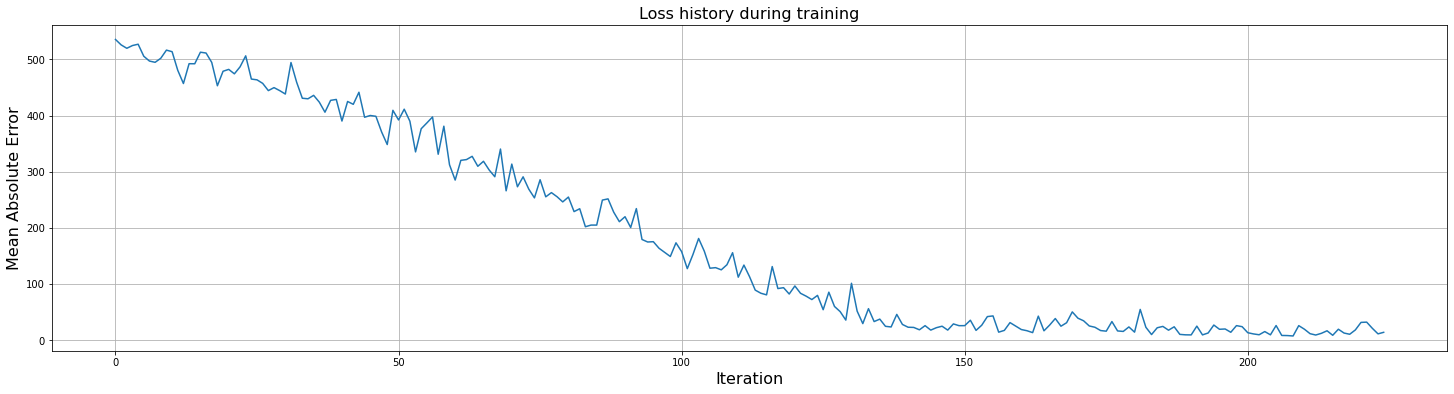

In [9]:
plot_loss(train_pipeline.v('loss_history'))

We can see that loss decreases during training and reaches a plateau. This indicates that the training procedure has converged.

## Inference
Following pipeline allows to calculate model's quality as a mean absolute value of the error between predicted and real times - Mean Absolute Error, or MAE

In [10]:
val_pipeline = (dataset.test.p
    # import trained model and initialize auxiliary variable
    .init_variable('mae', [])
    .import_model('fbp_model', train_pipeline)

    # data preprocessing
    .load(src='raw', combined=False)
    .scale_standard(src='raw')
    .make_model_inputs(src=BA('raw').data, dst='inputs', expand_dims_axis=1)

    # model prediction
    .predict_model('fbp_model', images=B('inputs'), fetches='predictions', save_to=B('predicted_picking'))

    # metric collection
    .update(V('mae', mode='e'), abs(BA('raw')['FirstBreak'].reshape(-1) - B('predicted_picking').reshape(-1)))

    # save predictions
    .update(BA('raw')['FirstBreakPred'], B('predicted_picking').reshape(-1))
    .call(lambda: BA('raw')[['FieldRecord', 'TraceNumber', 'FirstBreakPred']][:,0,:], save_to=B('picks'))
    .call(save_picking, 'submit_01.csv', B('picks'))
)
val_pipeline.run(BATCH_SIZE, n_epochs=1, drop_last=False, shuffle=False, bar='n')

  0%|                                                                                                         …

In [11]:
metrics = val_pipeline.v('mae')
print(f"Mean Absolute Error is {np.mean(metrics):.2f} samples")

Mean Absolute Error is 13.10 samples


## Model evaluation
Let's visualize the predictions of the model. Firstly, reindex the dataset by FieldRecord, in order to make predictions for gathers, not for traces.

In [12]:
dataset.test.index.reindex('FieldRecord', inplace=True)

Construct evaluation pipeline with a plot function in the end

/notebooks/Amsterdam21/FBP/../../SeismicPro/seismicpro/src/gather.py:997: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  y_ticks = {'formatter': IndexFormatter(self.samples.astype(np.int32))}


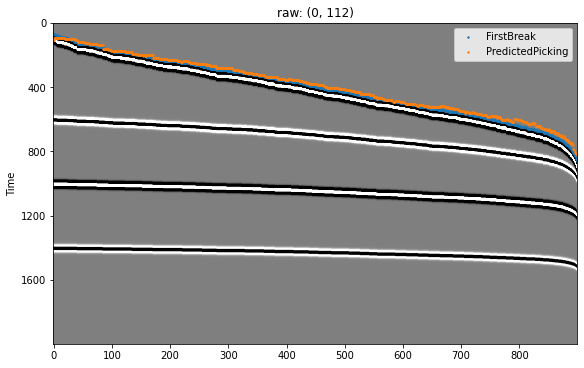

In [13]:
plot_pipeline = (dataset.test.p
    # import trained model
    .import_model('fbp_model', train_pipeline)

    # data preprocessing
    .load(src='raw')
    .scale_standard(src='raw')
    .make_model_inputs(src=BA('raw').data, dst='inputs', expand_dims_axis=1)

    # model prediction
    .predict_model('fbp_model', images=B('inputs'), fetches='predictions', save_to=B('predicted_picking'))

    # result prostprocessing
    .split_model_outputs(src=B('predicted_picking')[:, 0], dst=BA('raw')['PredictedPicking'], shapes=BA('raw').shape[:, 0])
    .sort(src='raw', by='offset')
    # plotting results
    .plot(src='raw', figsize=(8, 5), vmin=-1, vmax=1, points=dict(col_name=['FirstBreak', 'PredictedPicking'], s=2))
    )

plot_pipeline.next_batch(1)

### Conclusion
This simple model trained on a very small dataset does not perform well. But, given some effort and data, one can improve those results significantly. Good luck!